# Ratings Predictor - Project Group 6
Gillian Foster, Tristan Hsieh, Yulissa Montes, Ezra Rebollar

April 19, 2019 

50395

In [454]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time

# Semantic computing of moods based on tags in social media of music

#### Brief summary of Group 6's Data Analytics project:

Our group decided to use this dataset collected on 600 different songs published on Spotify that were rated on their "mood tags" from listeners in a study. These mood tags  are atmospheric, sad, arousal, sensual, tension, dark, valence, happy, and sentimental.


After reviewing the data, we believed we could make a model that could predict the rating of at least one mood, in this project we had arbitrarily chose sentimental. Through feature selection, binning of the data, and/or encoding features we sought to use Nearest Neighbor, Naive Bayes, and Clustering algorithms to analyze our data and make a prediction on what the rating would be for Sentimental, mimicking users' rating of the mood elicited by the song.   

### Step One: Organizing the Data

The data collected from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/TVYEGI is divided into six CSV files. Here, the data is collected into a single set and widdled into the relevant features.

In [455]:
attributes = pd.read_csv("attributes.csv")
print(attributes.isnull().sum())
ratings_mean = pd.read_csv("ratings_mean.csv")
print(ratings_mean.isnull().sum())
ratings_all = pd.read_csv("ratings_all.csv")
print(ratings_all.isnull().sum())
track_info = pd.read_csv("trackinfo.csv")
print(track_info.isnull().sum())

AttributeID      0
AttributeName    0
dtype: int64
TrackID        0
Valence        0
Arousal        0
Tension        0
Atmospheric    0
Happy          0
Dark           0
Sad            0
Angry          0
Sensual        0
Sentimental    0
dtype: int64
UserID         0
TrackID        0
Rating         0
AttributeID    0
dtype: int64
TrackID         0
LastfmID        0
Artist          0
Title           0
URL             0
SpotifyURL      0
ClipStart(s)    0
ClipEnd(s)      0
dtype: int64


__There is no null data in the selected dataset.__

__Some data, like clip start and end times, is more useful when consolidated. ClipLength and TitleLength are both derived features.__

In [456]:
track_info['TitleLength'] = track_info['Title'].str.len()
track_info['ClipLength'] = track_info["ClipEnd(s)"] - track_info["ClipStart(s)"]
track_info = track_info.drop(['LastfmID', 'URL', 'SpotifyURL','ClipStart(s)', 'ClipEnd(s)', 'Title'], axis=1)
track_info.head(10)

,TrackID,Artist,TitleLength,ClipLength
0,1,Autechre,4,14.875
1,2,Lalo Schifrin,23,29.925
2,3,Daft Punk,11,14.875
3,4,Portishead,10,29.925
4,5,The Rolling Stones,13,29.925
5,6,Tindersticks,16,29.925
6,7,FischerSpooner,16,14.875
7,8,Horace Silver,23,29.950
8,9,Janet Jackson,24,14.875
9,10,Chet Baker,25,29.925


__The AttributeIDs in ratings_all are replaced with the referenced Attribute.__

In [457]:
attributes = attributes.set_index('AttributeID')
attributesDict = attributes.to_dict()
attributesDict = attributesDict['AttributeName']

In [458]:
ratings_all = ratings_all.replace({'AttributeID': attributesDict})
ratings_all = ratings_all.rename(columns={'AttributeID' : 'Attribute'})
ratings_all.head(10)

,UserID,TrackID,Rating,Attribute
0,1,272,6,Happy
1,1,272,2,Dark
2,1,272,3,Sad
3,1,272,2,Angry
4,1,272,7,Sensual
5,1,272,6,Sentimental
6,1,272,4,Arousal
7,1,272,6,Valence
8,1,272,3,Tension
9,1,272,7,Atmospheric


### Finding the right dataframes and initial feature selection:

We agreed that dimensionality would be too high to use the actual ratings used in our ratings_all dataframe. 
data_means is already a mean of ratings from all the users in the study so to add these individual ones in the model would be redundant as well.
Hence, we just used our data_means data frame for our models and disregarded the data_ratings one.

In [459]:
data_ratings = ratings_all.merge(track_info, on='TrackID')
data_ratings.head(15)

,UserID,TrackID,Rating,Attribute,Artist,TitleLength,ClipLength
0,1,272,6,Happy,Efterklang,8,14.875
1,1,272,2,Dark,Efterklang,8,14.875
2,1,272,3,Sad,Efterklang,8,14.875
3,1,272,2,Angry,Efterklang,8,14.875
4,1,272,7,Sensual,Efterklang,8,14.875
5,1,272,6,Sentimental,Efterklang,8,14.875
6,1,272,4,Arousal,Efterklang,8,14.875
7,1,272,6,Valence,Efterklang,8,14.875
8,1,272,3,Tension,Efterklang,8,14.875
9,1,272,7,Atmospheric,Efterklang,8,14.875


In [460]:
data_means = track_info.merge(ratings_mean, on='TrackID')
data_means = data_means.drop(['TrackID'], axis=1)
data_means.head(10)

,Artist,TitleLength,ClipLength,Valence,Arousal,Tension,Atmospheric,Happy,Dark,Sad,Angry,Sensual,Sentimental
0,Autechre,4,14.875,3.7000,5.2414,7.3000,4.6667,2.4667,5.7333,3.0690,4.5172,2.2667,1.8000
1,Lalo Schifrin,23,29.925,7.6786,6.9286,3.7500,4.6786,7.1429,1.4074,1.8929,1.3929,2.4286,2.8571
2,Daft Punk,11,14.875,6.6897,2.1333,2.6000,7.2000,4.8966,2.2000,3.0345,1.2333,5.1333,4.1000
3,Portishead,10,29.925,4.1000,3.9333,5.1667,6.4667,2.4333,5.3333,5.9000,2.8621,6.0000,5.6333
4,The Rolling Stones,13,29.925,6.0345,3.8276,4.3793,5.4483,4.6667,2.2222,2.6897,2.6897,3.6786,4.1071
5,Tindersticks,16,29.925,5.8148,3.0714,3.5357,6.3793,3.8276,3.0000,5.3793,1.6897,4.6552,5.7586
6,FischerSpooner,16,14.875,4.4828,6.2000,6.4667,4.0345,3.4138,4.3667,3.7000,3.3333,2.3793,2.6667
7,Horace Silver,23,29.950,5.9310,5.4138,4.5517,5.6207,4.3214,2.0741,4.0000,1.8077,3.7931,3.3929
8,Janet Jackson,24,14.875,6.9310,7.2500,4.1786,4.6207,6.5517,1.6552,2.4138,1.6552,4.5000,3.9286
9,Chet Baker,25,29.925,5.3929,1.9643,2.8276,7.2069,2.7586,3.4138,5.7586,1.5862,6.0345,5.7586


### Step Two: Exploring the Data

Now combined into a single set, this explores some patterns in the data. We started with knowing how many rows and features we started with and saw the .describe() info, later visually shown in a boxplot.

In [461]:
# data describe and dimensions

print("dimensions of data_means:" + "\n" + "number of rows: " + str(data_means.shape[0]) + "\n" + "number of columns: " + str(data_means.shape[1]))
print()
data_means.describe()

dimensions of data_means:
number of rows: 600
number of columns: 13



,TitleLength,ClipLength,Valence,Arousal,Tension,Atmospheric,Happy,Dark,Sad,Angry,Sensual,Sentimental
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,14.913333,26.341208,5.436206,5.010788,4.771573,5.248452,4.037959,3.452491,3.959013,2.772385,3.519645,4.283908
std,7.928888,6.413236,1.195235,1.898004,1.453082,1.424241,1.411678,1.486005,1.268322,1.588414,1.328730,1.292418
min,3.000000,14.875000,1.866700,1.600000,2.069000,1.928600,1.448300,1.137900,1.321400,1.192300,1.206900,1.357100
25%,10.000000,29.925000,4.740700,3.178600,3.516100,4.133300,2.965500,2.264850,2.966400,1.642900,2.364300,3.248050
50%,14.000000,29.925000,5.631800,5.086200,4.638100,5.366700,3.929800,3.069000,3.931000,2.157550,3.454350,4.321400
75%,18.000000,29.925000,6.250000,6.720125,5.873250,6.437050,4.896600,4.381250,4.965500,3.403450,4.533900,5.291850
max,60.000000,30.000000,8.000000,8.551700,8.400000,8.069000,8.000000,8.066700,6.933300,8.428600,7.655200,7.413800


#### Computing pairwise correlation of sentimental to all other mood tags: 

Here we sought see if any particular mood being felt by the users would correlate with the sentimental mood. We learned in lectures that a correlation coefficient with an absolute value close to 1 is "strongly correlated" and with a value close to 0 indicates these two features have no relationship between each other. 

##### Note:
After seeing a wide range of correlation coefficients, we asked ourselves if removing moods with a value close to 0 would help our models.

In [462]:
# correlation coefiicient for all moods against "Sentimental" organized by absolute value

print("correlation coefficient for Sentimental vs. Atmospheric:", data_means['Sentimental'].corr(data_means['Atmospheric']))
print("correlation coefficient for Sentimental vs. Sad:", data_means['Sentimental'].corr(data_means['Sad']))
print("correlation coefficient for Sentimental vs. Arousal:", data_means['Sentimental'].corr(data_means['Arousal']))
print("correlation coefficient for Sentimental vs. Sensual:", data_means['Sentimental'].corr(data_means['Sensual']))
print("correlation coefficient for Sentimental vs. Tension:", data_means['Sentimental'].corr(data_means['Tension']))
print("correlation coefficient for Sentimental vs. Angry:", data_means['Sentimental'].corr(data_means['Angry']))
print("correlation coefficient for Sentimental vs. Dark:", data_means['Sentimental'].corr(data_means['Dark']))
print("correlation coefficient for Sentimental vs. Valence:", data_means['Sentimental'].corr(data_means['Valence']))
print("correlation coefficient for Sentimental vs. Happy:", data_means['Sentimental'].corr(data_means['Happy']))


correlation coefficient for Sentimental vs. Atmospheric: 0.7544399704393624
correlation coefficient for Sentimental vs. Sad: 0.7344198936886337
correlation coefficient for Sentimental vs. Arousal: -0.7146938692232553
correlation coefficient for Sentimental vs. Sensual: 0.7008375734092313
correlation coefficient for Sentimental vs. Tension: -0.6185503609410423
correlation coefficient for Sentimental vs. Angry: -0.5125949063539434
correlation coefficient for Sentimental vs. Dark: -0.1994732641335074
correlation coefficient for Sentimental vs. Valence: 0.17219959538823057
correlation coefficient for Sentimental vs. Happy: -0.08270548442427043


#### Box plot to visually show .describe() info on each mood:

Went with a boxplot so it would show the trends in each mood from 1-10, rather than their relationships with each other like in the previous correlation coefficient data exploration method.

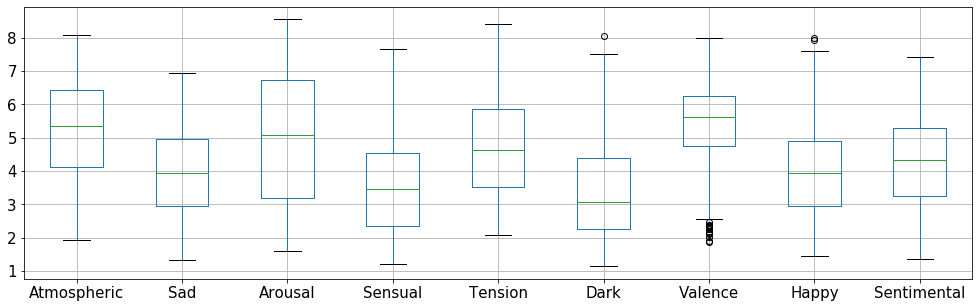

In [463]:
data_means.boxplot(column=["Atmospheric", "Sad", "Arousal", "Sensual", "Tension", "Dark", "Valence", "Happy", "Sentimental"], figsize=(17,5), fontsize=15)

__in this box plot we can see how close our data points might be with each other by mood and can be helpful when using algorithms like Nearest Neighbor and Clustering.__

## Step Three: applying the models 
Our group divided the work of data analysis into three different algorithms done by three seperate people and sought the highest prediction accuracy from each model. We used K - Nearest Neighbor, Naive Bayes, and Clustering methods and considered others like Decision Trees but felt there were too many class categories for Decision Trees to branch off and predict well.

### 1. KNN model approach:
The KNN algorithm assumes that similar things exist in close proximity. This model tried to fit to the data based on proximity and classified them as such from the binned values of Sentimental on a 1-10 scale of integers. 

#### Notes: 
I tried binning the means for the moods, dropping the lowest correlated moods, 
using a different range for n, using a different scaler, and even dropping title length to improve accuracy.

In [464]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

##### Note:
Since every song in our dataset had a different Artist, and Artist name length was not a good feature to help with accuracy being binned or not, I decided to drop this

In [465]:
data_means['Artist'].describe()

count                  600
unique                 600
top       Natalie Merchant
freq                     1
Name: Artist, dtype: object

In [466]:
new_data_means = data_means.drop(["Artist"], axis=1) 

# I also considered dropping title length too, but that didn't help with accuracy
#new_data_means = new_data_means.drop("TitleLength", axis=1) 

#### Binning the features: 
As a group, we saw the increase in accuracy our models had when binning different features. Each bin values are unique from one another depending on the best accuracy given. Binning helps with models by binning continous data into ranges and here I just round down to the nearest integer. 

In [467]:
new_labels = ['0','1','2','3','4','5','6','7','8','9']
sectors = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# bin all the means... this didn't seem to effect the results, but I left it here just in case.
new_data_means["Valence"] = pd.cut(data_means["Valence"], bins=sectors, labels=new_labels)
new_data_means["Arousal"] = pd.cut(data_means["Arousal"], bins=sectors, labels=new_labels)
new_data_means["Tension"] = pd.cut(data_means["Tension"], bins=sectors, labels=new_labels)
new_data_means["Atmospheric"] = pd.cut(data_means["Atmospheric"], bins=sectors, labels=new_labels)
new_data_means["Happy"] = pd.cut(data_means["Happy"], bins=sectors, labels=new_labels)
new_data_means["Dark"] = pd.cut(data_means["Dark"], bins=sectors, labels=new_labels)
new_data_means["Sad"] = pd.cut(data_means["Sad"], bins=sectors, labels=new_labels)
new_data_means["Angry"] = pd.cut(data_means["Angry"], bins=sectors, labels=new_labels)
new_data_means["Sensual"] = pd.cut(data_means["Sensual"], bins=sectors, labels=new_labels)

sentimentalBinned = pd.cut(data_means["Sentimental"], bins=sectors, labels=new_labels)
new_data_means["Sentimental"] = sentimentalBinned # Sentimental data is now binned too

In [468]:
new_data_means # final data frame to use for KNN model

,TitleLength,ClipLength,Valence,Arousal,Tension,Atmospheric,Happy,Dark,Sad,Angry,Sensual,Sentimental
0,4,14.875,3,5,7,4,2,5,3,4,2,1
1,23,29.925,7,6,3,4,7,1,1,1,2,2
2,11,14.875,6,2,2,7,4,2,3,1,5,4
3,10,29.925,4,3,5,6,2,5,5,2,5,5
4,13,29.925,6,3,4,5,4,2,2,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...
595,7,14.875,4,4,4,6,2,3,5,2,4,5
596,13,29.925,4,2,5,6,2,5,5,2,2,4
597,20,29.925,5,3,3,5,3,3,5,1,3,5
598,15,29.925,2,8,7,2,1,7,3,8,1,2


##### Implementtion of KNN model:
In KNN, it is important to scale the data so here we scaled the data and split it into two parts, training and test sets.

In [469]:
# create a set of features to be scaled. Labels will remain the same
scaled_data_features = new_data_means.drop("Sentimental", axis=1)

scaled_data_class = new_data_means["Sentimental"]

scaler = MinMaxScaler() # create a MinMaxScaler
scaler.fit(scaled_data_features) # fit the data
scaledData = scaler.transform(scaled_data_features) # scale the data and set "scaledData" equal to it

scaled_data_features = pd.DataFrame(data=scaledData) # turn the data back into a dataframe

# split the scaled data using the 80-20 rule
scaled_features_train, scaled_features_test, scaled_class_train, scaled_class_test = train_test_split(scaled_data_features, scaled_data_class, test_size=0.20)



##### KNN's prediction accuracy and detailed report:
We see that this was our `best performing model` to this dataset than Clustering and Naive Bayes approach we also took. This model was able to predict with a `48-50% accuracy` the rating that users would give `sentimental` of that particular song. 

In the `support` column in the `classification_report` we see that this model did outperform the rest in true classifications. This approach was able to classify the data based on proximity but we also learn that clustering did not perform well. Although the data did not have a clustering tendency the classifiers were close enough to predict a class with some accuracy with this lazy learning method. 

In [470]:
# now create the KNN model, the n is unknown
KNNmodel = KNeighborsClassifier()
KNNmodel.fit(scaled_features_train,scaled_class_train)

# set up the parameter grid to contain 100 possible values for n
param_grid = {
    'n_neighbors': [e for e in range(1,100)]
}

# grid search to find the optimal value of n, betweeen 1 and 100
grid_search = GridSearchCV(KNNmodel, param_grid, cv=5, scoring='accuracy') # perform a grid search with the given parameters
grid_search.fit(scaled_features_train,scaled_class_train) # fit the data

print("best n for nearest neighbors: ", grid_search.best_params_.get('n_neighbors')) # print whichever n was considered the best


print("accuracy: ", cross_val_score(grid_search.best_estimator_,scaled_features_train,scaled_class_train,cv=10).mean()) # now print the accuracy

# The following is for a more detailed report
KNNpred = cross_val_predict(KNNmodel, scaled_features_test, scaled_class_test, cv=10) 
print()
# print(confusion_matrix(scaled_class_test, KNNpred))
print(classification_report(scaled_class_test, KNNpred))


best n for nearest neighbors:  2
accuracy:  0.4931320670112016

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.61      0.74      0.67        19
           3       0.57      0.71      0.63        24
           4       0.33      0.36      0.35        33
           5       0.46      0.39      0.43        33
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         1

    accuracy                           0.47       120
   macro avg       0.28      0.31      0.30       120
weighted avg       0.43      0.47      0.44       120



### 2. Naive Bayes model approach:
The Naive Bayes is a lazy learner that assumes that the features are independent from one another. NB describes the probability of a feature, based on prior knowledge of conditions that might be related to that feature. We tried this model to see if there was any probabilistic approach to predicting the mean rating for a mood.

#### Notes:
i saw the best accuracy when playing with different bin sizes for our mood means, Clip Length, or Title song Length. Even dropped moods according to correlation coefficient to improve accuracy.

##### More data exploration:
Binning here was done with analysis of the four quartile ranges of the column when looking at Title Length or Clip Length to see if these categories could be helpful for the model in their buckets. 

In [471]:
data_means["TitleLength"].describe()

count    600.000000
mean      14.913333
std        7.928888
min        3.000000
25%       10.000000
50%       14.000000
75%       18.000000
max       60.000000
Name: TitleLength, dtype: float64

In [472]:
data_means["ClipLength"].describe()

count    600.000000
mean      26.341208
std        6.413236
min       14.875000
25%       29.925000
50%       29.925000
75%       29.925000
max       30.000000
Name: ClipLength, dtype: float64

Found that clip length was split between rounded values of 15 and 30 so best way to bin this feature wasn't based on mean like title length would be

In [473]:
# four quartile ranges buckets
new_labels = ['3','10','14','18', '60']
sectors = [0, 3, 10, 14, 18, 60]
TitleLengthBinned = pd.cut(data_means["TitleLength"], bins=sectors, labels=new_labels)

# 15 or 30 second clip length buckets
new_labels = ['15', '30']
sectors = [0, 15, 31]
ClipLengthBinned = pd.cut(data_means["ClipLength"], bins=sectors, labels=new_labels)

# integer buckets
new_labels = ['0','1','2','3','4','5','6','7','8','9']
sectors = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sentimentalBinned = pd.cut(data_means["Sentimental"], bins=sectors, labels=new_labels)
sentimentalBinned.head(10)

0    1
1    2
2    4
3    5
4    4
5    5
6    2
7    3
8    3
9    5
Name: Sentimental, dtype: category
Categories (10, object): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]

In [474]:
data_means_copy = data_means.copy() # make a copy of data_means to use for model

# complete binning tasks ifor data_means_copy
data_means_copy["Artist Length"] = data_means_copy["Artist"].str.len()
data_means_copy = data_means_copy.drop(['Artist'], axis=1)


data_means_copy["TitleLengthBinned"] = TitleLengthBinned
data_means_copy = data_means_copy.drop(['TitleLength'], axis=1)


data_means_copy["ClipLengthBinned"] = ClipLengthBinned
data_means_copy = data_means_copy.drop(['ClipLength'], axis=1)


data_means_copy["SentimentalBinned"] = sentimentalBinned
data_means_copy = data_means_copy.drop(['Sentimental'], axis=1)

In [475]:
data_means_copy

,Valence,Arousal,Tension,Atmospheric,Happy,Dark,Sad,Angry,Sensual,Artist Length,TitleLengthBinned,ClipLengthBinned,SentimentalBinned
0,3.7000,5.2414,7.3000,4.6667,2.4667,5.7333,3.0690,4.5172,2.2667,8,10,15,1
1,7.6786,6.9286,3.7500,4.6786,7.1429,1.4074,1.8929,1.3929,2.4286,13,60,30,2
2,6.6897,2.1333,2.6000,7.2000,4.8966,2.2000,3.0345,1.2333,5.1333,9,14,15,4
3,4.1000,3.9333,5.1667,6.4667,2.4333,5.3333,5.9000,2.8621,6.0000,10,10,30,5
4,6.0345,3.8276,4.3793,5.4483,4.6667,2.2222,2.6897,2.6897,3.6786,18,14,30,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,4.9630,4.4138,4.1379,6.8276,2.9655,3.3448,5.8621,2.2414,4.8276,19,10,15,5
596,4.0345,3.0000,5.3214,6.1786,2.0714,5.6786,5.8571,2.6429,2.8929,12,14,30,4
597,5.3448,3.6552,3.7931,5.8621,3.6207,3.4828,5.5517,1.9286,3.5517,10,60,30,5
598,2.1724,8.1034,7.9643,2.7143,1.4483,7.1724,3.4828,8.2414,1.2857,6,18,30,2


#### __Feature Selection for NB:__
took moods off that were not correlated with sentimental and since NB is a probabilistic approach it would help to do this. 

In [476]:
data_means_copy = data_means_copy.drop(['Happy'], axis=1)
data_means_copy = data_means_copy.drop(['Valence'], axis=1)
data_means_copy = data_means_copy.drop(['Dark'], axis=1)
data_means_copy = data_means_copy.drop(['Angry'], axis=1)
data_means_copy = data_means_copy.drop(['Tension'], axis=1) # had the highest correlation coefficient of dropped moods

# didnt improve accuracy and all 600 songs had different artist names
data_means_copy = data_means_copy.drop(['Artist Length'], axis=1)

# dropped these columns after binning after accuracy didnt improve.
data_means_copy = data_means_copy.drop(['TitleLengthBinned'], axis=1)
data_means_copy = data_means_copy.drop(['ClipLengthBinned'], axis=1)

In [489]:
data_means_copy # final dataframe for NB model

,Arousal,Atmospheric,Sad,Sensual,SentimentalBinned
0,5.2414,4.6667,3.0690,2.2667,1
1,6.9286,4.6786,1.8929,2.4286,2
2,2.1333,7.2000,3.0345,5.1333,4
3,3.9333,6.4667,5.9000,6.0000,5
4,3.8276,5.4483,2.6897,3.6786,4
...,...,...,...,...,...
595,4.4138,6.8276,5.8621,4.8276,5
596,3.0000,6.1786,5.8571,2.8929,4
597,3.6552,5.8621,5.5517,3.5517,5
598,8.1034,2.7143,3.4828,1.2857,2


#### Implementation of NB model:
Now that data has been explored and features have been selected, now will split the data for testing and training NB model.

In [478]:

from sklearn.model_selection import train_test_split
# all data except lebel
data_features = data_means_copy.drop(["SentimentalBinned"], axis=1)

# should include "label"s
data_class = data_means_copy["SentimentalBinned"]

# split data into training and test set (proportions: 80 and 20)
features_train, features_test, class_train, class_test = train_test_split(data_features, data_class, test_size=0.20)
# print(type(features_train))
print("features_train=",features_train.shape, " class_train=", class_train.shape)
print("features_test=",features_test.shape, " class_test=", class_test.shape)
print()
print("class test:")
print(class_test)

features_train= (480, 4)  class_train= (480,)
features_test= (120, 4)  class_test= (120,)

class test:
471    2
175    1
519    5
540    2
114    3
      ..
141    6
108    4
30     3
531    4
555    4
Name: SentimentalBinned, Length: 120, dtype: category
Categories (10, object): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]


#### NB model accuracy:
the `NB model did not perform as well as we hoped` with this data but we did get about `45-50% accuracy` (more detailed report below) on predicting a class with 10 labels. We could therefore predict the mean rating of a mood of `10 different categories` and being `correct half the time`.

In [479]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
clf = GaussianNB()

# Train the model using the training sets
clf.fit(features_train, class_train)

from sklearn.model_selection import cross_val_score

# saw the best accuracy converge to 47%
scores = cross_val_score(clf, features_train, class_train, cv=10) 
print("Scores:", scores)                                            
print()
print("Accuracy:", scores.mean()*100)

Scores: [0.47058824 0.52       0.44897959 0.45833333 0.4375     0.5106383
 0.40425532 0.4893617  0.40425532 0.5       ]

Accuracy: 46.43911798762058


#### detailed report and predictions:
from the `classification_report` we can see that in the `support` column shows that `the moods with the higher correlation coefficient performed better to help predict our mean rating`. Therefore, using a a probabilistic approach with this data did perform with some poor accuracy but if we had recieved more data, perhaps our model could perform better with this lazy learning approach. In addition, this model had the highest f1-score so maybe using this model, although it might not perform as well, compared to the other models would be best since the f1-score uses the precision and recall in its computation. 

In [480]:
from sklearn.model_selection import cross_val_predict

# cross val but gives predictions
predictions = cross_val_predict(clf, features_test, class_test, cv=10) 
# print("predictions:", predictions)

from sklearn.metrics import confusion_matrix
# used to print matrix
# print(confusion_matrix(data_class, predictions))

# report on per class basis
from sklearn.metrics import classification_report
print(classification_report(class_test, predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.39      0.46      0.42        26
           3       0.29      0.16      0.21        25
           4       0.41      0.41      0.41        27
           5       0.56      0.58      0.57        31
           6       0.36      0.57      0.44         7
           7       0.00      0.00      0.00         2

    accuracy                           0.41       120
   macro avg       0.29      0.31      0.29       120
weighted avg       0.40      0.41      0.40       120



### __3. DBSCAN model approach:__

DBSCAN is a clustering method, where we define `Eps` and `MinPts` so that our model can partially cluster our data and label each data point as `noise`, `border`, or `core` point. The reason we decided to test this method against other clustering methods is because we're not sure if the data is globular or has a strong clustering tendency. DBSCAN could potentially cluster the moods in our dataset. 

Here we are scaling our data prior to running our algorithm & performing dimensionality reduction utilizing PCA

In [481]:
# importing required modules
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, silhouette_score

In [482]:
from sklearn.model_selection import train_test_split
# all data except lebel
data_features = data_means.drop(["Sentimental"], axis=1)

# should include "label"s
data_class = data_means["Sentimental"]

# split data into training and test set (proportions: 80 and 20)
features_train, features_test, class_train, class_test = train_test_split(data_features, data_class, test_size=0.20)
# print(type(features_train))
print("features_train=",features_train.shape, " class_train=", class_train.shape)
print("features_test=",features_test.shape, " class_test=", class_test.shape)
print()
print("class test:")
print(class_test)

features_train= (480, 12)  class_train= (480,)
features_test= (120, 12)  class_test= (120,)

class test:
570    4.3793
408    5.1786
53     5.6207
147    5.2000
356    6.9643
        ...  
417    5.7000
171    5.8000
344    3.5926
320    3.2143
199    5.5862
Name: Sentimental, Length: 120, dtype: float64


In [483]:
# standardizing data & converting back to a usable dataframe
features_train_db = features_train.drop(['Artist'], axis=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features_train_db)
scaled_df = pd.DataFrame(scaled_data)
print("Scaled Data:", scaled_df.shape)

# performing PCA
pca = PCA(n_components=0.95, svd_solver='full')
pca_array = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(pca_array)

print("PCA data:", pca_df.shape)
pca_df.head()

Scaled Data: (480, 11)
PCA data: (480, 6)


,0,1,2,3,4,5
0,-1.894120,-0.531528,0.467331,-0.456799,-0.898720,-0.296650
1,-1.659268,-2.001755,-1.224363,0.939617,0.416204,-0.049257
2,-0.814266,3.065121,-0.630433,-1.049974,-0.433633,-0.580388
3,-1.043726,-1.111604,0.399362,-0.578563,0.763012,-0.469290
4,3.299555,-1.538626,0.688188,-0.444278,0.020128,0.076546


Now we will utilize `NearestNeighbors` and `kneighbors` to find the distance of each point to its 4th nearest neighbor. We will plot the sorted distances to set an appropriate `Eps` value for DBSCAN.

[[0.19712671 0.33917866 0.40185771 0.55821657]
 [0.19712671 0.36579299 0.51009198 0.55854671]
 [0.24817    0.38384885 0.54766951 0.59960182]
 ...
 [2.50982238 2.81819313 3.54566038 3.56745036]
 [2.56944146 3.15413283 4.00098184 4.04959483]
 [2.81819313 3.59389021 4.41913059 4.45267587]]


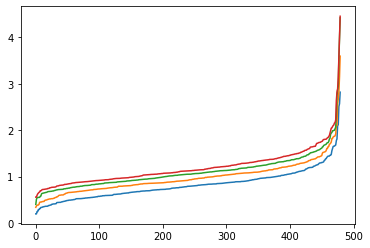

In [484]:
nn = NearestNeighbors(n_neighbors=4)
nn.fit(pca_df)
distances, indices = nn.kneighbors()
sorted_distances = np.sort(distances, axis=0)
print(sorted_distances)

plt.plot(sorted_distances)
plt.show()

In [485]:
# we will attempt to cluster with an Eps value of 2
cluster = DBSCAN(eps=2, min_samples=4)
pred = cluster.fit_predict(pca_df)
labels = cluster.labels_

# converting numpy arrary to series
pred_series = pd.Series(pred)

In [486]:
# function provided to us to plot 
import random as rand
from sklearn.manifold import MDS

def scatter(data, labels, numPoints = 300):
    
    numEntries = data.shape[0]
    start = rand.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data.iloc[start:end, :]
    labels = labels.iloc[start:end]
    
    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data.iloc[:, :-1])
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

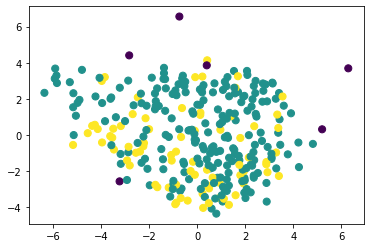

In [487]:
scatter(pca_df, pred_series)

Now we will calculate the silhouette score for the model. We see that this indicates that the model did not fill well to the data, as it is low. A possible explination would be that the distances beteween the points were not meaningful enough or that the dataset did not have a strong clustering tendency. Therefore inferring by this and the scatter plot above, that DBSCAN was not a good fit for this particular dataset.

In [488]:
# calculating silhouette score
s_score = silhouette_score(pca_df, pred_series)
print("Silhouette score:", s_score)

Silhouette score: 0.1424471471117406


### Outcome/Results:

In conclusion, we found we were able to create three models that could predict the mean rating given from hundreds of user inputs on one specific mood from 1 - 10 for a particular song with an accuracy of 40-50%. Through data exploration and many trial and errors of feature selection, our models could now predict how a song would rank in a specific mood given data based off of the songs general info and other moods elicited by it. 

#### Final Decision: 
we saw that the KNN model performed the best and, in real world application, would choose this one to submit. 

##### Real World Application of this model:
Artists and producers in the music industry could `use this model to predict the rating that music consumers would rate a mood` felt from the song. This would benefit them if they were trying to `segment the market by a specific mood elicited in the song`. Mood Media is a company that uses sound to help sell retail items and could also use this model as they sell a music subscription to set the `mood` in their stores. Abercombie and Hollister could be Mood Media consumers that want a specific mood to be set in their stores based on their customer base of younger generations. 